# Import libraries

In [43]:
from sklearn.model_selection import train_test_split
from yahoo_fin import stock_info as si
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import os

# v0.2 imports
import mplfinance as fplt
import matplotlib.pyplot as plt

In [45]:
def load_data(ticker, TEST_START='2020-01-01', TEST_END='2023-01-01', scale=True, shuffle=True, dropNaN=True, split_by_ratio=True, split_by_date=False, split_date=None, test_size=0.2, feature_columns=["adjclose", "volume", "open", "high", "low"]):
    """
    Loads data from yahoo finance, then scaling, shuffle, and normalization.
    :param ticker: (str/pd.DataFrame), the ticker you want to load, like META, AAPL,...
    :param TEST_START: str, the start date of the test data (format: "YYYY-MM-DD")
    :param TEST_END: str, the end date of the test data (format: "YYYY-MM-DD")
    :param scale: whether to scale prices between 0 and 1, default is True
    :param shuffle: bool, whether to shuffle the dataset (both training and testing), default is True
    :param dropNaN: bool, whether to drop NaN values, default is True
    :param split_by_date: bool, whether to split the data into training and testing by date, default is True
    :param test_size: ratio of test data to train data, default is 0.2 (80% for training and 20% for testing)
    :param feature_columns: the list of features to feed into the model, default is everything grabbed from yahoo_fin
    :return: 
    """
    
    # ------------------------------------------------------------------------------------------------#
    # Ticket to csv file, put it into folder dataset
    ticker_data_filename = os.path.join("dataset", f"{ticker}_{TEST_START}_{TEST_END}.csv") 
    ## a, see if ticker is already a loaded stock from yahoo finance
    if os.path.exists(ticker_data_filename):
        print(f'Loading data from {ticker_data_filename}')
        # read csv file, take date column as index
        df = pd.read_csv(ticker_data_filename, index_col=0)
    else:
        print(f'Downloading data for {ticker} from yahoo finance')
        if not os.path.exists("dataset"):
            os.makedirs("dataset")
        # download data from yahoo finance before assign into dataframe
        df = si.get_data(ticker, TEST_START, TEST_END)
         ## d, Store the download data locally for future use
        df.to_csv(ticker_data_filename)
    # ------------------------------------------------------------------------------------------------#



    # ------------------------------------------------------------------------------------------------#
    ## b, Allow you to deal with the NaN issue in the data

    # drop NaNs or fill nan with mean
    if dropNaN:
        df.dropna(inplace=True)
    else:
        df.fillna(df.mean())
    # ------------------------------------------------------------------------------------------------#
    
    # this will contain all the elements we want to return from this function
    result = {'df': df.copy()}

    # we will also return the original dataframe itself

    # ------------------------------------------------------------------------------------------------#
    ## c, use different methods to split the data into train/test data; 
    # e.g. you can split it according to some specified ratio of train/test and you can specify to split it by date or randomly
    if split_by_ratio:
        # split the dataset into training & testing sets by date (not randomly splitting)
        train_samples = int((1 - test_size) * len(df))
        
        # :train_samples means from the beginning to train_samples, and train_samples: means from train_samples to the end
        result['df_train'] = df[:train_samples]
        result['df_test'] = df[train_samples:]
        
    elif split_by_date and split_date is not None:
        # Convert split_date to a datetime object
        split_date = pd.to_datetime(split_date)
        
        # Split by date on the index
        result['df_train'] = df[df.index <= split_date]  # Take data from the start to split_date
        result['df_test'] = df[df.index > split_date]  # Take data after split_date to the end

    else:
        # If neither split by ratio nor split by date, randomly split the dataset
        result['df_train'], result['df_test'] = train_test_split(df, test_size=test_size, shuffle=shuffle)
    # ------------------------------------------------------------------------------------------------#



   
    # ------------------------------------------------------------------------------------------------#
    ## e, scale the feature columns and store the scalers in data structure 
    if scale:
       result['column_scaler'] = df[feature_columns]
       scale_min_max = MinMaxScaler(feature_range=(0, 1))
       result['column_scaler'] = scale_min_max.fit_transform(result['column_scaler'])
       result['column_scaler'] = pd.DataFrame(result['column_scaler'], columns = feature_columns)
    # ------------------------------------------------------------------------------------------------#
    
    return result

In [65]:
# Amazon stock market
TICKER = "AMZN"

# Start and End date to read:
TEST_START = '2020-01-01'
TEST_END = '2023-01-01'

# whether to scale feature columns & output price as well
SCALE = True

# lookup step, 1 is the next day
LOOKUP_STEP = 15

# drop rows with NaN values
DROP_NAN = True

# whether to shuffle the dataset
SHUFFLE = True

# whether to split the training/testing set by date
SPLIT_BY_DATE = False

# test radio size, 0.2 is 20%
TEST_SIZE = 0.2

# features to use
FEATURE_COLUMNS = ["adjclose", "volume", "open", "high", "low", "close"]

In [66]:
data = load_data(ticker=TICKER, TEST_START=TEST_START, TEST_END=TEST_END, scale=SCALE, dropNaN=True,
          shuffle=SHUFFLE, split_by_date=SPLIT_BY_DATE, test_size=TEST_SIZE, feature_columns=FEATURE_COLUMNS)

Loading data from dataset/AMZN_2020-01-01_2023-01-01.csv


In [67]:
data["df"].head()

,open,high,low,close,adjclose,volume,ticker
2020-01-02,93.750000,94.900497,93.207497,94.900497,94.900497,80580000,AMZN
2020-01-03,93.224998,94.309998,93.224998,93.748497,93.748497,75288000,AMZN
2020-01-06,93.000000,95.184502,93.000000,95.143997,95.143997,81236000,AMZN
2020-01-07,95.224998,95.694504,94.601997,95.343002,95.343002,80898000,AMZN
2020-01-08,94.902000,95.550003,94.321999,94.598503,94.598503,70160000,AMZN


In [68]:
data["column_scaler"]

,adjclose,volume,open,high,low,close
0,0.124873,0.182574,0.111054,0.108587,0.114992,0.124873
1,0.113875,0.163828,0.106060,0.102972,0.115161,0.113875
2,0.127197,0.184897,0.103920,0.111287,0.112988,0.127197
3,0.129097,0.183700,0.125085,0.116136,0.128460,0.129097
4,0.121990,0.145664,0.122012,0.114762,0.125756,0.121990
...,...,...,...,...,...,...
751,0.032744,0.100584,0.011172,0.021868,0.015729,0.032744
752,0.011647,0.100054,0.027534,0.017780,0.016405,0.011647
753,0.000000,0.103400,0.006892,0.000000,0.003752,0.000000
754,0.022530,0.091949,0.007558,0.010174,0.012058,0.022530


# Improve to v0.2: Include charts

In [69]:
def display_stock_candlestick(data, n=1, title='Candlestick chart'):
    """
    Write a function to display stock market financial data using candlestick chart
    :param data: pd.DataFrame, stock market data with columns ['Open', 'High', 'Low', 'Close', 'Volume']
    :param n: trading days
    :param title: show the chart title
    :return: 
    """
    # check if index column is datetime
    if not isinstance(data.index, pd.DataFrame):
        data.index = pd.to_datetime(data.index)
    
    # allow each candle stick to express the data of `n` trading days
    if n >= 1:
        # Resample the data to aggregate over 'n' trading days
        data = data.resample(f'{n}D').agg({
            'open' : 'first',
            'high' : 'max',
            'low' : 'min',
            'close' : 'last',
            'volume' : 'sum'
        }).dropna()

    # plot the candlestick chart
    fplt.plot(
        data,
        type='candle',
        style='charles',
        title=title,
        ylabel='Price ($)',
        volume=True,
        ylabel_lower='Shares\nTraded'
    )


/opt/miniconda3/envs/OptionBStkPredictPrice/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


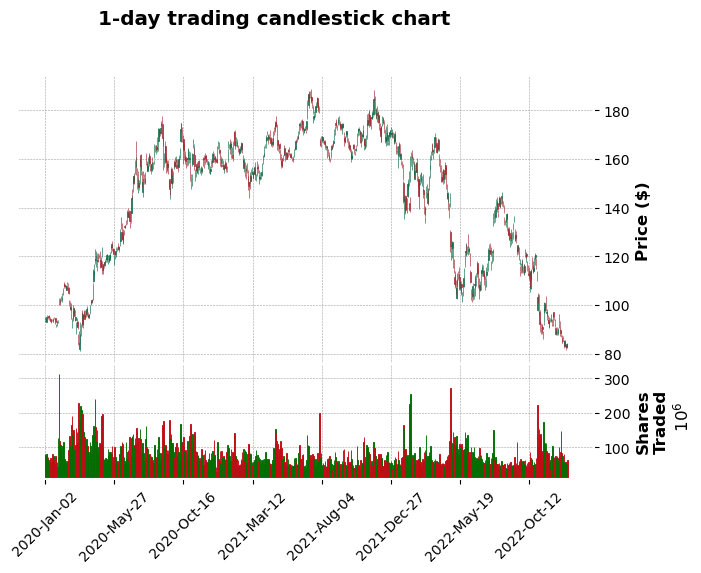

In [70]:
display_stock_candlestick(data["df"], n=1, title='1-day trading candlestick chart')

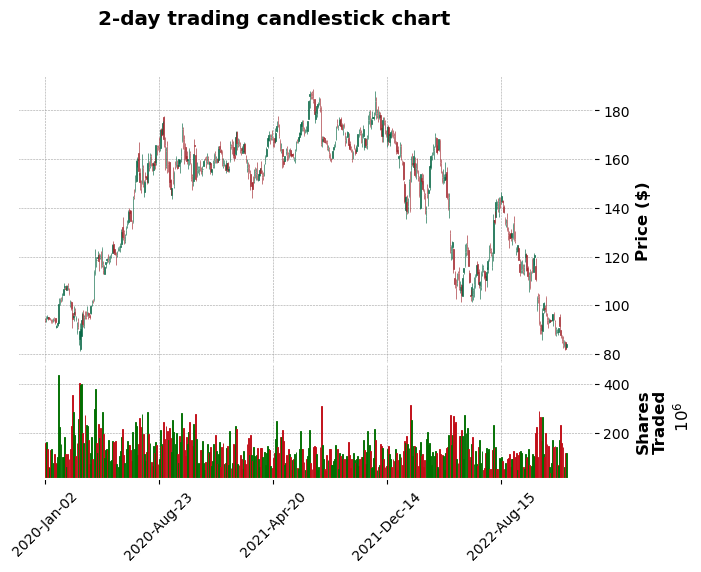

In [71]:
display_stock_candlestick(data["df"], n=2, title='2-day trading candlestick chart')

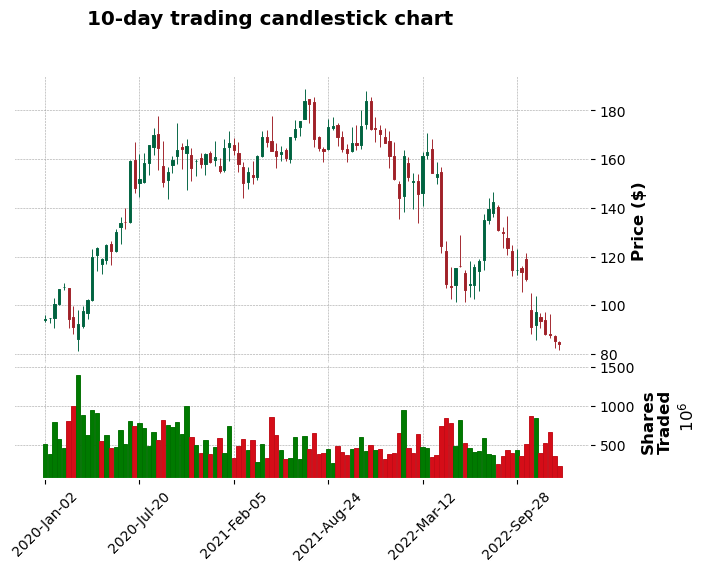

In [72]:
display_stock_candlestick(data["df"], n=10, title='10-day trading candlestick chart')

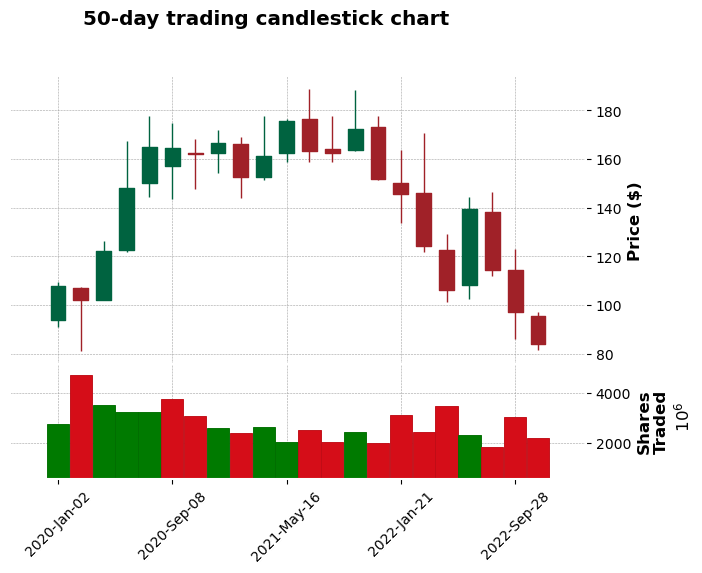

In [73]:
display_stock_candlestick(data["df"], n=50, title='50-day trading candlestick chart')

# Write a function to display stock market financial data using boxplot chart. 
This is particularly useful when you are trying to display your data for a moving window of `n`
consecutive trading days. Again, feel free to use online resources that teach you how to
this but you need to add comments to explain your codes and the parameters you use.

In [74]:
def plot_stock_boxplot(data, columns, figsize=(10, 7), title='Boxplot for Stock Data'):
    
    # Check data is in dataframe format
    if not isinstance(data, pd.DataFrame):
        print("Data must be DataFrame")
        return
    
    data_show = data[columns]
    plt.figure(figsize=figsize)
    plt.boxplot(data_show.values, labels=columns)
    plt.title(title, fontsize=16)
    plt.ylabel('Values')
    plt.show()


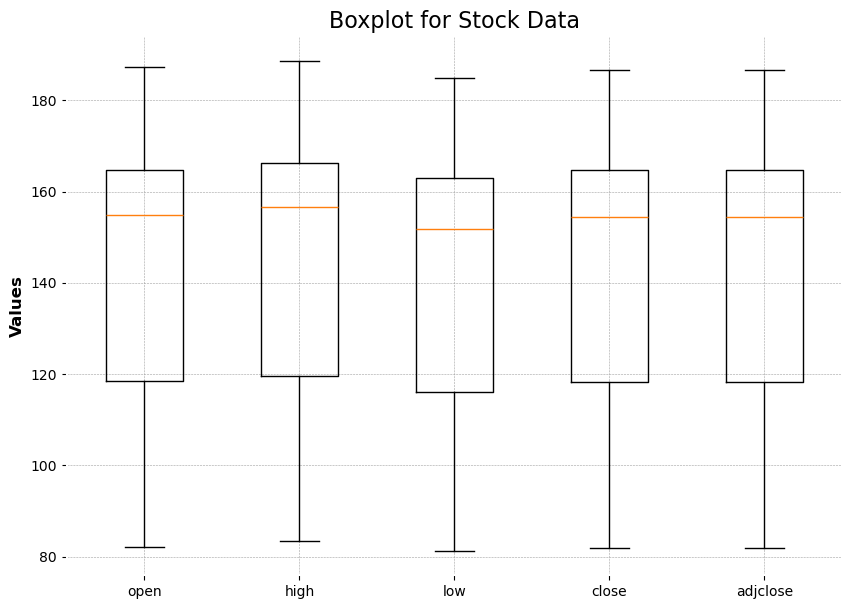

In [75]:
columns = ['open', 'high', 'low', 'close', 'adjclose']
plot_stock_boxplot(data["df"],columns)

In [76]:
def plot_moving_window_boxplot(data, columns, n, figsize=(10, 7), title='Boxplot for Stock Data'):
    """
    This function generates a boxplot for the specified stock data over a moving window of n days.
    
    Parameters:
    data (DataFrame): The entire dataset containing stock data.
    columns (list): The list of column names for which the boxplot will be generated (e.g., 'open', 'high', 'low').
    n (int): The window size (number of days) to use for the boxplot. Must be between 1 and the number of rows in the data.
    figsize (tuple): Optional; the size of the plot (default is (10, 7)).
    title (str): the title of the boxplot (default is 'Boxplot for Stock Data').
    """
    
    # Check if the window size 'n' is within valid bounds.
    if n < 1 or n > len(data):
        raise ValueError(f"The window size n must be >= 1 and <= the number of rows: {len(data)} in the data.")
    
    # Extract the first 'n' rows of data for the selected columns to create the moving window.
    window_data = data[columns].iloc[:n]

    # Create a new figure with the specified size for the boxplot.
    plt.figure(figsize=figsize)
    
    # Generate a boxplot using the values of the selected columns within the moving window.
    plt.boxplot(window_data.values, labels=columns)
    
    # Set the title of the boxplot, incorporating the window size 'n'.
    plt.title(f'{title}  with {n} days)', fontsize=16)
    
    # Label the y-axis as 'Values'.
    plt.ylabel('Values')
    
    # Display the plot.
    plt.show()

# Example usage:
columns = ['open', 'high', 'low', 'close', 'adjclose']

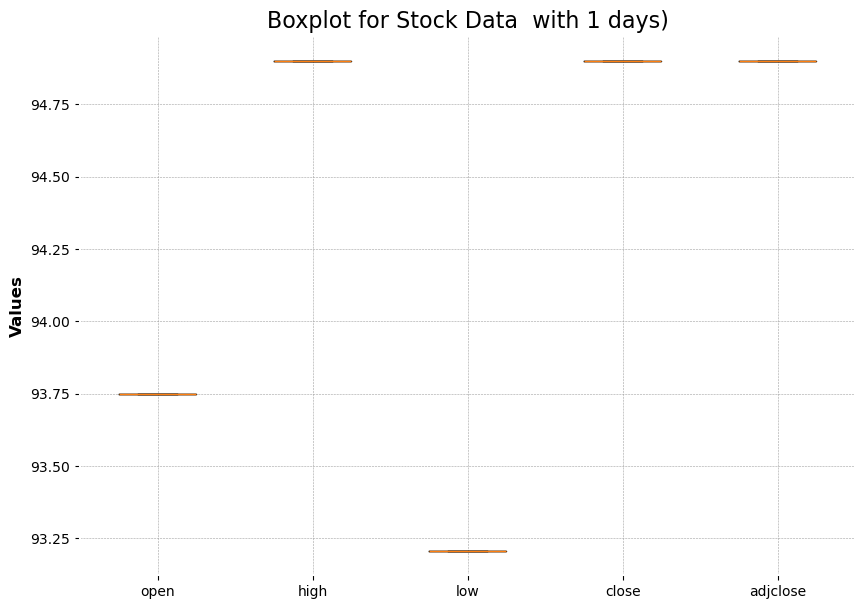

In [77]:
plot_moving_window_boxplot(data["df"], columns, n=1)

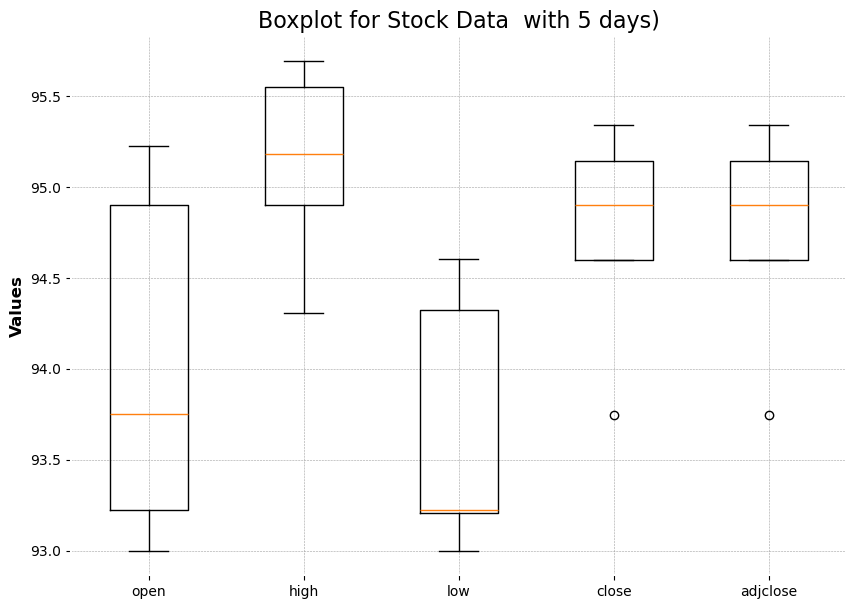

In [78]:
plot_moving_window_boxplot(data["df"], columns, n=5)

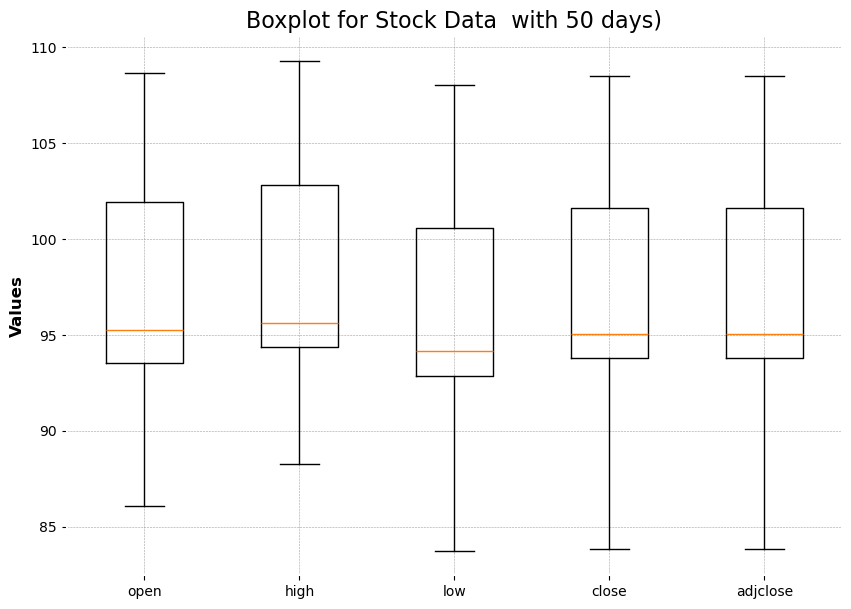

In [79]:
plot_moving_window_boxplot(data["df"], columns, n=50)

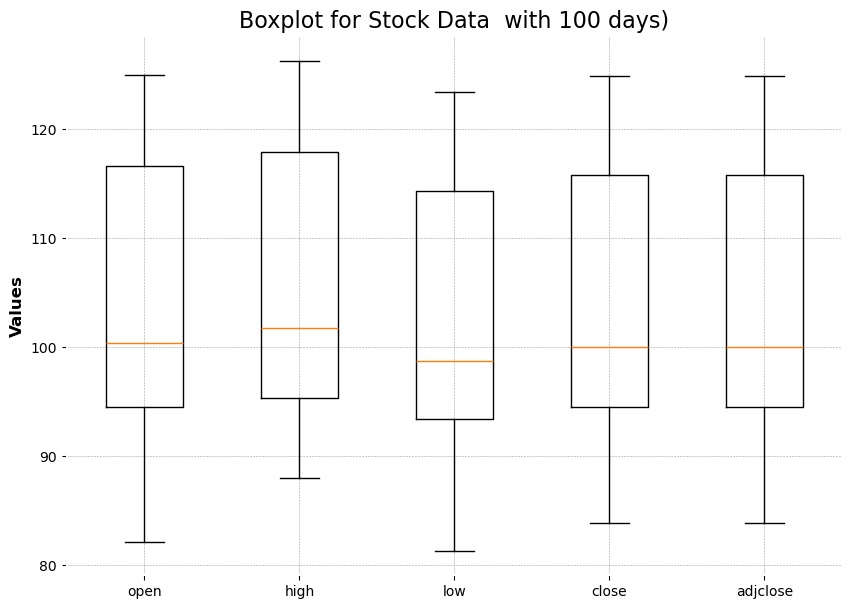

In [80]:
plot_moving_window_boxplot(data["df"], columns, n=100)